In [2]:
from dopamine.colab import utils as colab_utils
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
import os

# Save high dpi figures
plt.rcParams['savefig.dpi'] = 300
sns.set_theme(style='white')

In [3]:
def get_folder_names(folder_path):
    """
    Returns a list of names of all the subfolders in the given folder path.

    :param folder_path: Path to the folder
    :return: List of subfolder names
    """
    folder_names = []
    with os.scandir(folder_path) as entries:
        for entry in entries:
            if entry.is_dir():
                folder_names.append(entry.name)
    return folder_names

def get_latest_run(folder_path):
    """
    Returns the iteration number of the latest run by finding the maximum iteration number from the filenames in the given folder.

    :param folder_path: Path to the folder containing run files
    :return: The latest iteration number as an integer
    """
    filenames = os.listdir(folder_path)
    try:
        # Remove macos hidden file
        filenames.remove('.DS_Store')
    except ValueError:
        pass
    
    if not filenames:
        raise ValueError(f'No log data found at {folder_path}')

    def extract_iteration(x):
        return int(x[x.rfind('_') + 1:])

    latest_iteration = max(extract_iteration(x) for x in filenames)
    return latest_iteration

def read_game_runs(folder_path, exploration_methods):
    """
    Reads game runs for different exploration methods and organizes the data.

    :param folder_path: Base path where the game run data is stored
    :param exploration_methods: List of exploration methods to be considered
    :return: A DataFrame containing the game run data
    """
    latest_run = get_latest_run(folder_path)
    parameter_set = OrderedDict([
        ('method', exploration_methods),
        ('run', range(latest_run + 1))
    ])
    data = colab_utils.read_experiment(folder_path, parameter_set, job_descriptor='{}_{}', verbose=False,
                                        summary_keys=['train_episode_returns'])
    return data

def plot_individual_game_runs(game, data, ax):
    """
    Plots the game runs using the provided data.

    :param game: Name of the game to be plotted
    :param data: DataFrame containing the game run data
    :param ax: The matplotlib axis where the plot will be drawn
    """
    # Update method names
    data['method'] = data['method'].apply(lambda x: format_method_names([x])[0])

    sns.lineplot(x='iteration', y='train_episode_returns', hue='method', data=data, ax=ax)

    # n_runs = int(data['run'].max() + 1)

    ax.set_title(f'{game}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Return')
    # ax.legend_.remove()
    ax.grid(color='black', linestyle='-', linewidth=0.2)

def format_method_names(methods):
    """
    Formats the method names for better readability and standardization.

    :param methods: A list of method names as strings
    :return: A list of formatted method names
    """
    formatted_names = []
    for method in methods:
        # Replace underscore with space
        method = method.replace('_', ' ')
        # Capitalize first letter of each word
        method = ' '.join(word.capitalize() for word in method.split())
        # Noisy to Noisy Nets
        method = method.replace('Noisy', 'Noisy Nets')
        # Replace 'e-greedy' and 'ez-greedy' with the \epsilon symbol
        method = method.replace('E-greedy', '$\epsilon$-greedy').replace('Ez-greedy', '$\epsilon z$-greedy')
        # Capitalize VPD and SimHash
        method = method.replace('Vpd', 'VPD').replace('Simhash', 'SimHash')
        
        method = method.replace('VPD SimHash', 'VDSC')
        
        formatted_names.append(method)
    return formatted_names


In [4]:
def plot_combined_game_runs(games, n_cols, n_rows, col_size, row_size, methods_to_plot, csv_folder_path, save_fig_name, all_57=False):
    if all_57:
        font_size = 20
    else:
        font_size = 12
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(col_size * n_cols, row_size * n_rows), sharey=False)
    axs = axs.flatten()
    legends = []

    for i, game in enumerate(games):
        game_csv_path = f'{csv_folder_path}/{game}.csv'
        try:
            data = pd.read_csv(game_csv_path)
        except FileNotFoundError:
            print(f'One or both CSV files not found for game: {game}')
            continue
            
        # Filter methods
        filtered_data = data[data['method'].isin(methods_to_plot)]
        # Format method names
        filtered_data.loc[:, 'method'] = filtered_data['method'].apply(lambda x: format_method_names([x])[0])

        if not all_57:
            custom_palette = {
                '$\epsilon$-greedy': '#1f77b4',
                'Noisy Nets': '#ff7f0e',
                'Boltzmann': '#2ca02c',
                'VDSC': '#d62728',
                'VPD': '#9467bd',
                'SimHash': '#8c564b'
            }
            hue_order = ['$\epsilon$-greedy', 'Noisy Nets', 'Boltzmann', 'VDSC', 'VPD', 'SimHash']

            sns.lineplot(x='iteration', y='train_episode_returns', hue='method', data=filtered_data, ax=axs[i],
                         errorbar="ci", palette=custom_palette, hue_order=hue_order, linewidth=1.0)
        else:
            custom_palette = {
                'Rainbow': '#1f77b4',
                'VDSC': '#d62728'
            }
            hue_order = ['Rainbow', 'VDSC']
            
            sns.lineplot(x='iteration', y='train_episode_returns', hue='method', data=filtered_data, ax=axs[i],
                         palette=custom_palette, hue_order=hue_order, errorbar="ci")
        
        if game in ["Pong", "Freeway"] and not all_57:
            # Create zoomed-in plot
            axins = axs[i].inset_axes([0.4, 0.1, 0.5, 0.7])
            sns.lineplot(x='iteration', y='train_episode_returns', hue='method', data=filtered_data, ax=axins, errorbar="ci",
                         palette=custom_palette, hue_order=hue_order)
            
            # Set limits for zoomed-in plot
            y_min, y_max = axs[i].get_ylim()
            y_min = abs(y_min + y_max)/2
            axins.set_ylim(y_min, y_max)
            axins.set_xlim(0, 30)
            
            axins.legend_.remove()
            
            axins.set_xlabel('')
            axins.set_xticklabels([])
            
            axins.set_ylabel('')
            axins.set_yticklabels([])
            
            # Mark the region that is plotted on the main axes
            axs[i].indicate_inset_zoom(axins, edgecolor="black")
            
        handles, labels = axs[i].get_legend_handles_labels()
        legends.append((handles, labels))
    
        axs[i].set_title(f'{game}', fontsize=font_size)

        axs[i].legend_.remove()
    
        if i >= len(games) - n_cols:
            axs[i].set_xlabel('Environment frames', fontsize=font_size-4)
        else:
            axs[i].set_xlabel('')
            axs[i].set_xticklabels([])
    
        if i % n_cols == 0 and not all_57:
            axs[i].set_ylabel('Return', fontsize=font_size)
        else:
            axs[i].set_ylabel('')

        if all_57:
            # axs[i].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            axs[i].tick_params(axis='both', which='major', labelsize=font_size-4, width=1, length=5)
            axs[i].yaxis.offsetText.set_fontsize(font_size)
    
    axs[len(games)].remove()
        
    lgd = fig.legend(handles=legends[0][0], labels=legends[0][1], loc='lower center', bbox_to_anchor=(0.5, -0.03),
                     ncol=len(methods_to_plot), fontsize=font_size if all_57 else 'medium')
    
    plt.tight_layout()
    
    fig.savefig(save_fig_name + ".pdf", format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [13]:
ALL_GAMES = []

with open('../../atari-game-list.txt', "r") as f:
    for line in f:
        ALL_GAMES.extend(line.split())

ALL_GAMES = sorted(ALL_GAMES)
ALL_GAMES.remove('Defender')

In [14]:
print(ALL_GAMES)

['AirRaid', 'Alien', 'Amidar', 'Assault', 'Asterix', 'Asteroids', 'Atlantis', 'BankHeist', 'BattleZone', 'BeamRider', 'Berzerk', 'Bowling', 'Boxing', 'Breakout', 'Carnival', 'Centipede', 'ChopperCommand', 'CrazyClimber', 'DemonAttack', 'DoubleDunk', 'ElevatorAction', 'Enduro', 'FishingDerby', 'Freeway', 'Frostbite', 'Gopher', 'Gravitar', 'Hero', 'IceHockey', 'Jamesbond', 'Kangaroo', 'Krull', 'KungFuMaster', 'MontezumaRevenge', 'MsPacman', 'NameThisGame', 'Phoenix', 'Pitfall', 'Pong', 'Pooyan', 'PrivateEye', 'Qbert', 'Riverraid', 'RoadRunner', 'Robotank', 'Seaquest', 'Skiing', 'Solaris', 'SpaceInvaders', 'StarGunner', 'Tennis', 'TimePilot', 'Tutankham', 'UpNDown', 'Venture', 'VideoPinball', 'WizardOfWor', 'YarsRevenge', 'Zaxxon']


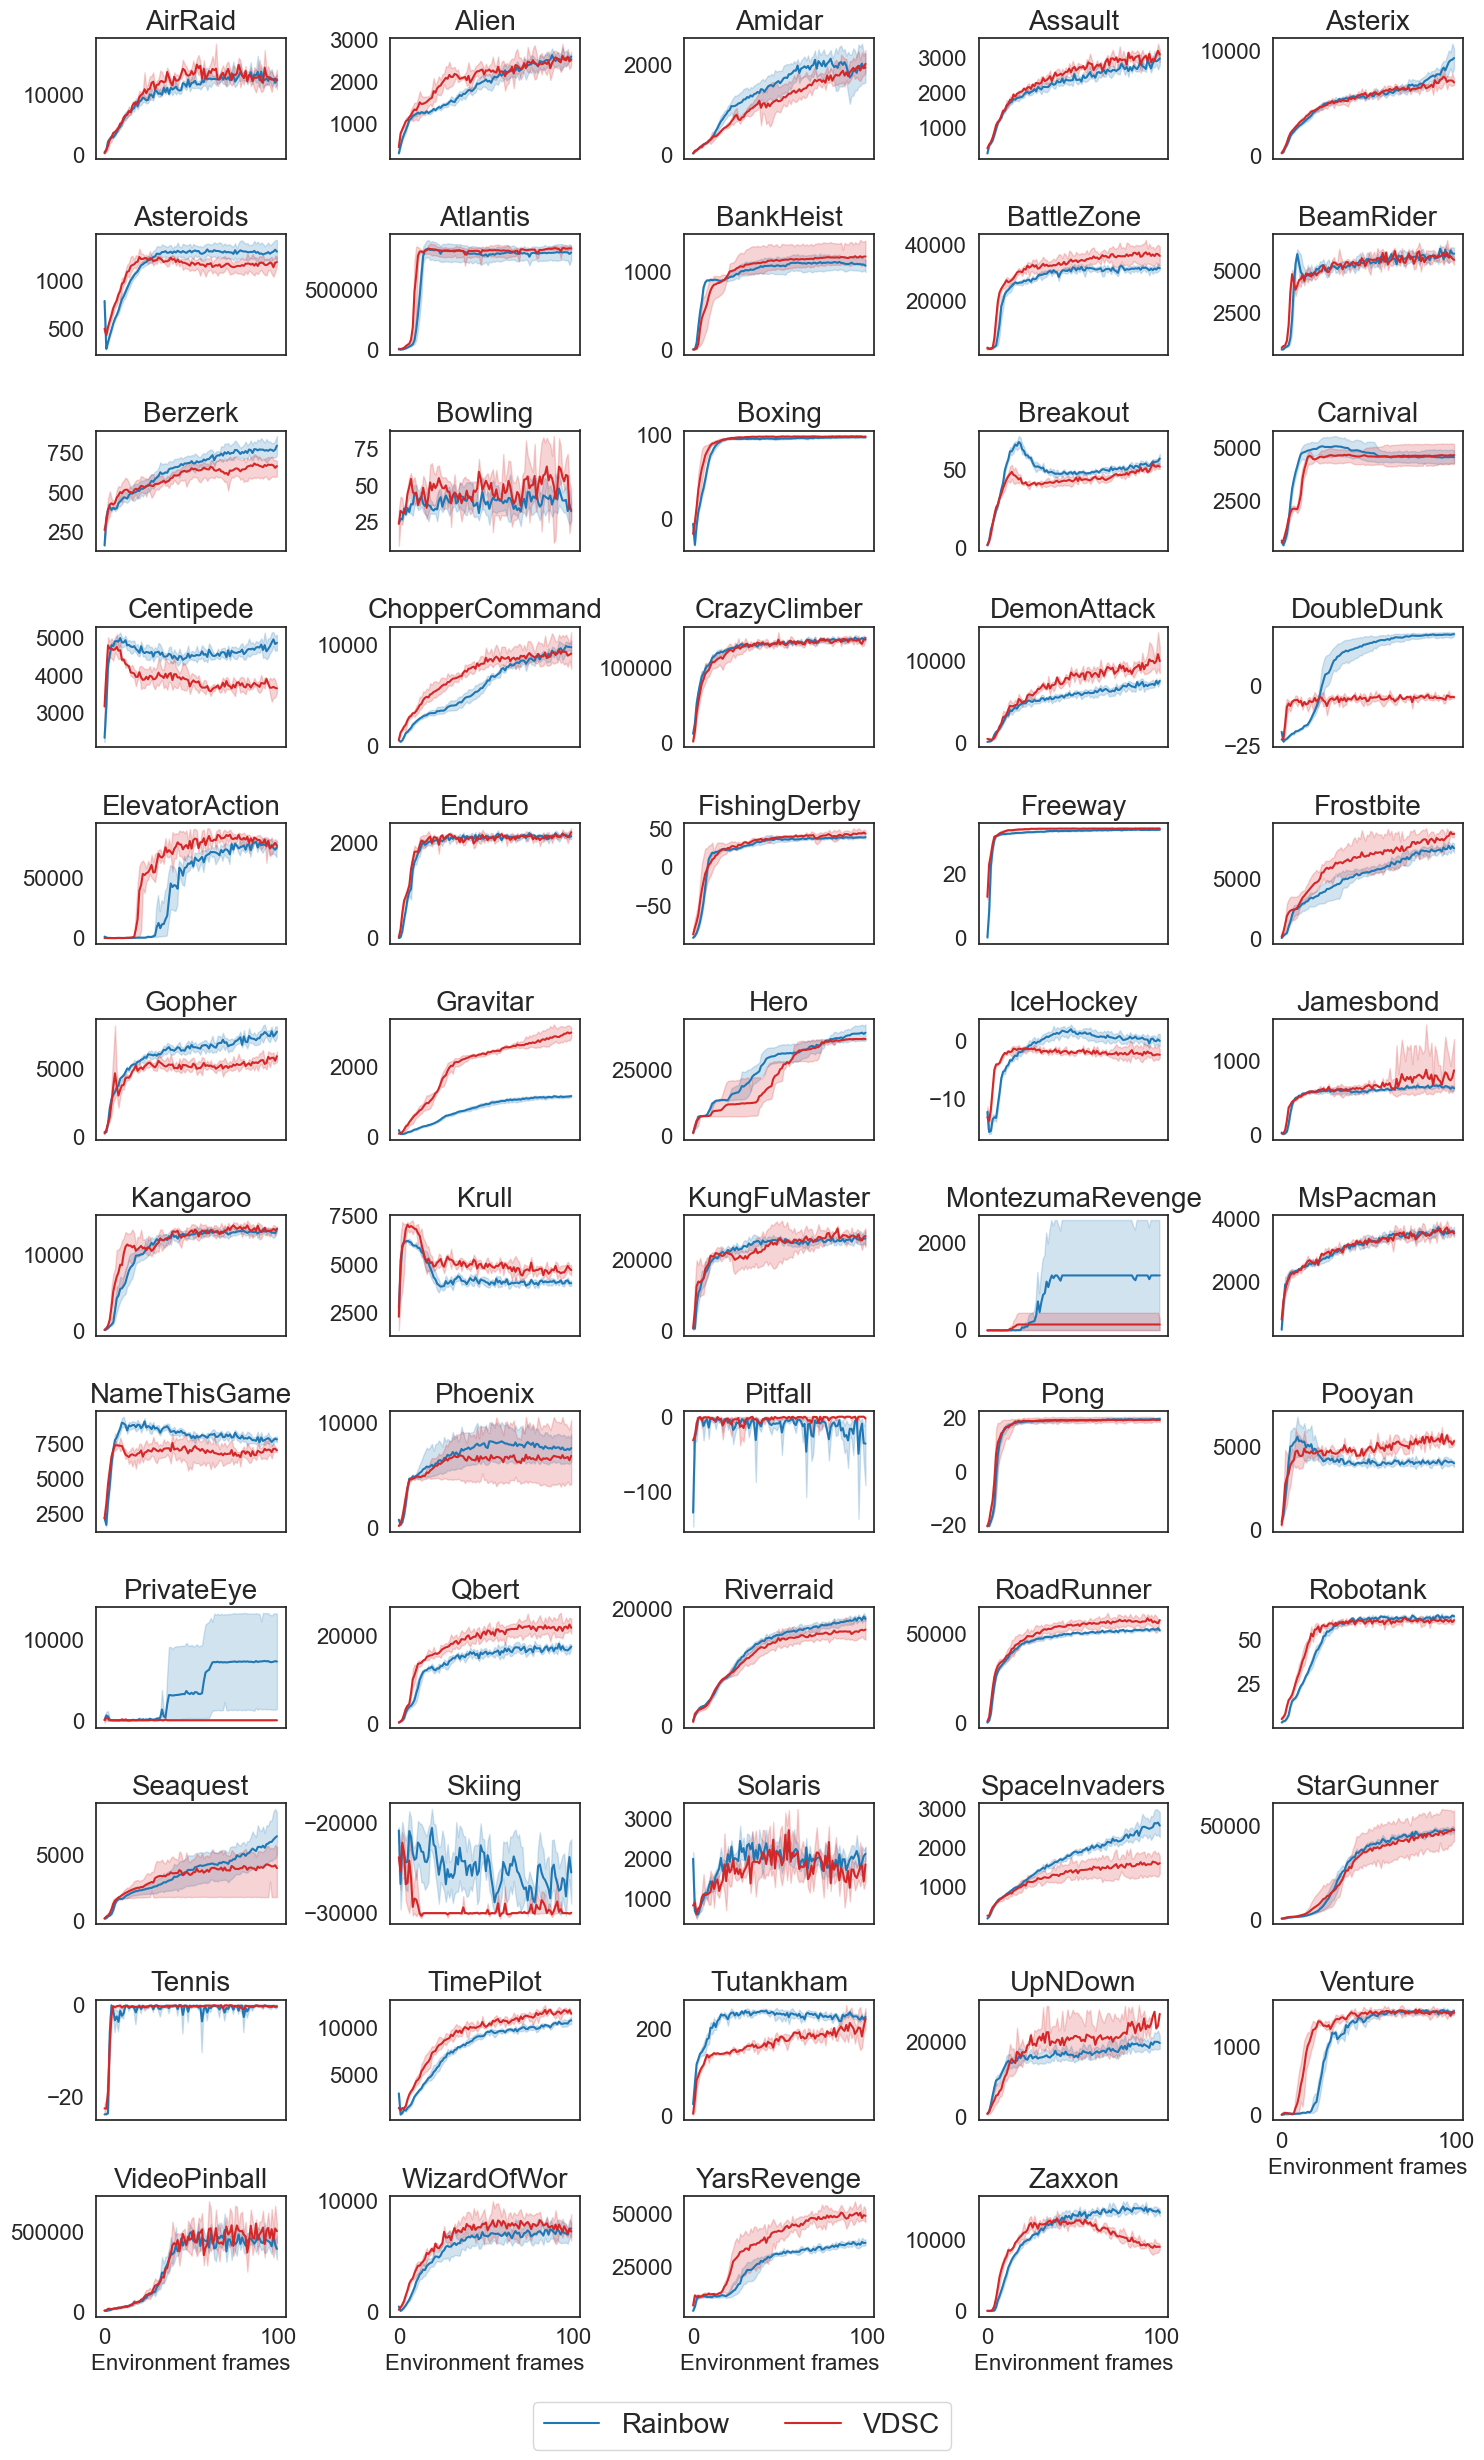

In [15]:
# 4 Atari games, all methods
# plot_combined_game_runs(games=['Pong', 'Frostbite', 'Gravitar', 'Freeway'], n_cols=2, n_rows=2,
#                         col_size=4, row_size=3,
#                         methods_to_plot=['e-greedy', 'noisy', 'boltzmann', 'vpd_simhash', 'vpd', 'simhash'],
#                         csv_folder_path='../../results/atari/csv',
#                         save_fig_name='atari-vs-baselines')

# All Atari games
plot_combined_game_runs(games=ALL_GAMES, n_cols=5, n_rows=((len(ALL_GAMES) // 5) + 1),
                        col_size=3, row_size=2,
                        methods_to_plot=['vpd_simhash', 'Rainbow'],
                        csv_folder_path='../../results/atari/csv', save_fig_name='atari-57',
                        all_57=True)